In [1]:
import sys
import os
import torch
import scipy.io
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
def load_svhn_data(data_dir='../data/raw', split='train'):      # '../data/raw' is where I put my data files. Change it to yours
    """
    Loads SVHN cropped digit data from .mat files.
    
    Args:
        data_dir (str): Path to the folder containing .mat files.
        split (str): 'train' or 'test'.
        
    Returns:
        X (np.array): Images of shape (N, 32, 32, 3) -> Normalized [0, 1]
        y (np.array): Labels of shape (N,) -> Corrected so '0' is class 0 (not 10)
    """
    file_path = os.path.join(data_dir, f'{split}_32x32.mat')
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}. Please download it from http://ufldl.stanford.edu/housenumbers/")

    print(f"Loading {split} data from {file_path}...")
    mat_data = scipy.io.loadmat(file_path)
    
    # The .mat file has X shape: (32, 32, 3, N) -> (Height, Width, Channels, Batch)
    # We want standard shape: (N, 32, 32, 3) for visualization/processing
    X = mat_data['X']
    X = np.transpose(X, (3, 0, 1, 2))
    
    # Normalize pixel values to [0, 1] range (Standard for Deep Learning)
    X = X.astype('float32') / 255.0

    # The .mat file has y shape: (N, 1). Flatten it to (N,)
    y = mat_data['y'].flatten()
    
    # FIX LABELS: SVHN labels '0' as 10. We need to map 10 -> 0.
    y[y == 10] = 0
    
    print(f"Loaded {X.shape[0]} samples.")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y

In [3]:
print("Loading Data...")
X_train, y_train = load_svhn_data('../data/raw', split='train')
X_val, y_val = load_svhn_data('../data/raw', split='test')

Loading Data...
Loading train data from ../data/raw/train_32x32.mat...
Loaded 73257 samples.
X shape: (73257, 32, 32, 3)
y shape: (73257,)
Loading test data from ../data/raw/test_32x32.mat...
Loaded 26032 samples.
X shape: (26032, 32, 32, 3)
y shape: (26032,)


In [4]:
# Define standard ResNet Normalization (required for pre-trained weights)
# Mean and Std for ImageNet dataset which is the pre-training model we using, NOT RADNOM DATA but actual statistic from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

ResNet-18 Residual Neural Network with 18 layers is what we used

In [5]:
def preprocess_for_resnet(X, y, batch_size, shuffle):
    # 1. Convert to Tensor (N, 32, 32, 3) -> (N, 3, 32, 32)
    tensor_x = torch.Tensor(X).permute(0, 3, 1, 2)
    
    # 2. Normalize channel-wise manually
    # (ResNet expects normalized inputs)
    for c in range(3):
        tensor_x[:, c, :, :] = (tensor_x[:, c, :, :] - mean[c]) / std[c]
        
    tensor_y = torch.Tensor(y).long()
    
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

About ResNet, its basically NN with many layers, but with specialy residual layers that allows complex deep network to still be able to retain original gradients features. How is this done: Ouput(x) = F(F(x)) + x, the input x is passed to both NN and added again after two NN layers sums up the output. 


In [6]:
train_loader = preprocess_for_resnet(X_train, y_train, batch_size=64, shuffle=True)
val_loader = preprocess_for_resnet(X_val, y_val, batch_size=64, shuffle=False)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Load pre-trained ResNet18
# 'weights="DEFAULT"' loads the best available ImageNet weights
resnet = models.resnet18(weights="DEFAULT")     # this down loads the pre-trained weights

# Freeze all layers (Optional: Unfreeze later for better accuracy)
# We freeze them so we don't destroy the pre-trained knowledge initially
# for param in resnet.parameters():
#     param.requires_grad = False         # this is pretrained, so this preevents updating weights

# Replace the final fully connected layer (fc)
# In_features is 512 for ResNet18. We change output to 10 classes.
num_ftrs = resnet.fc.in_features    
resnet.fc = nn.Linear(num_ftrs, 10) 

In [9]:
# Move to GPU
resnet = resnet.to(device)
# It physically moves the model's parameters from your computer's RAM to the GPU's VRAM. 
# If you don't do this, the GPU can't perform calculations on it.

In [10]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the final layer (fc) parameters initially
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

Starting Transfer Learning...
Epoch 1/5 | Train Loss: 0.7166 | Val Error: 10.12%
Epoch 2/5 | Train Loss: 0.3158 | Val Error: 8.76%
Epoch 3/5 | Train Loss: 0.2327 | Val Error: 7.50%
Epoch 4/5 | Train Loss: 0.1818 | Val Error: 7.44%
Epoch 5/5 | Train Loss: 0.1454 | Val Error: 7.04%


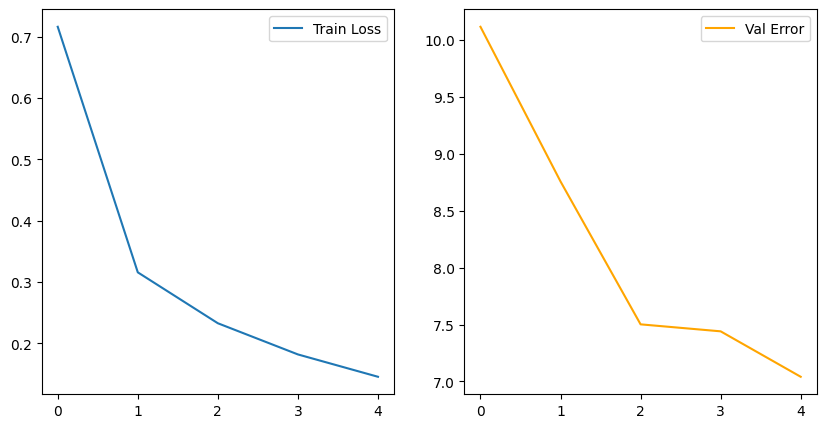

In [11]:
num_epochs = 5 # Transfer learning converges fast!
train_losses = []
val_errors = []

print("Starting Transfer Learning...")

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_acc = 100 * correct / total
    val_error = 100 - val_acc
    val_errors.append(val_error)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Error: {val_error:.2f}%")

# Plot Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_errors, label='Val Error', color='orange')
plt.legend()
plt.show()